# Caso : Un modelo de ocupación de camas de hospital 


Los pacientes llegan a una tasa promedio dada, donde el tiempo entre dos pacientes muestreados provienen de una distribución exponencial así como la duración de la estadía en el hospital. Suponemos aquí que la sala del hospital puede expandirse para hacer frente a los picos de demanda, y usar el modelo para observar la variación natural esperada en la ocupación de las camas de la sala [Ref](https://pythonhealthcare.org/2018/04/13/60-simpy-a-simple-bed-occupancy-model/).

In [1]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

## Almacenamiento de variables

Almacenaremos variables globales en una clase, g. Las variables se denominan g.var_name. No es estrictamente necesario, pero es una forma conveniente de permitir que las funciones cambien directamente las variables globales 

In [2]:
class g():
    # Global variables
    bed_count=0
    inter_arrival_time=1
    los=10 # length of stay
    sim_duration=500
    audit_time=[]
    audit_beds=[]
    audit_interval=1 # bed occupancy is measured at this interval

## Generando nuevas llegadas


In [3]:
def new_admission(env,interarrival_time,los):
    i=0
    while True:
        i+=1
        p_los=random.expovariate(1/los) # sample length of stay for patient
        p=patient(env,i,p_los) # generate a patient
        env.process(p) # activate the patient
        next_p=random.expovariate(1/interarrival_time) # sample next arrival time
        # print('Next patient in %f3.2' %next_p)
        yield env.timeout(next_p) # set up next arrival

## Camino del paciente

Cuando llega un nuevo paciente, la ocupación de la cama del hospital aumenta en uno. Luego se desencadena un retraso para ese paciente de acuerdo con la duración de su estadía. Al final de ese tiempo de espera, el paciente se va y la ocupación de la cama se reduce en uno.

In [9]:
def patient(env,i,p_los):
    g.bed_count+=1 # adjust global variable for occupied beds
    # print('Patient %d arriving %7.2f, bed count %d' %(i,env.now,g.bed_count))
    yield env.timeout(p_los) # set delay according to length of stay
    g.bed_count-=1
    # print('Patient %d leaving %7.2f, bed count %d' %(i,env.now,g.bed_count))

## Auditoria de camas

La auditoría se ejecuta a intervalos de tiempo regulares. Cada vez que se ejecuta, se agrega a dos listas globales: una registra el tiempo simulado y la otra el número de camas actualmente ocupadas.

In [ ]:
def audit_beds(env,delay):
    yield env.timeout(delay)
    while True:
        g.audit_time.append(env.now)
        g.audit_beds.append(g.bed_count)
        yield env.timeout(g.audit_interval)

## Generar informe de auditoria

Al final de la ejecución de la simulación, se genera un informe de auditoría para resumir la variación de ocupación de camas de hospital.

In [4]:
def build_audit_report():
    audit_report=pd.DataFrame()
    audit_report['Time']=g.audit_time
    audit_report['Occupied_beds']=g.audit_beds
    audit_report['Median_beds']=audit_report['Occupied_beds'].quantile(0.5)
    audit_report['Beds_5_percent']=audit_report['Occupied_beds'].quantile(0.05)
    audit_report['Beds_95_percent']=audit_report['Occupied_beds'].quantile(0.95)
    return audit_report

## Visualización

In [5]:
def chart():
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Occupied_beds'],
             color='k',marker='o',linestyle='solid',
             markevery=1,label='Occupied beds')
    
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Beds_5_percent'],
             color='0.5',linestyle='dashdot',
             markevery=1,label='5th percentile')
    
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Median_beds'],
             color='0.5',linestyle='dashed',
             label='Median')
    
    plt.plot(g.audit_dataframe['Time'],
             g.audit_dataframe['Beds_95_percent'],
             color='0.5',linestyle='dashdot',
             label='95th percentile')
    
    plt.xlabel('Day')
    plt.ylabel('Occupied beds') 
    plt.title('Occupied beds (individual days with 5th, 50th and 95th percentiles)')
    #plt.legend()
    plt.show()


## Código principal

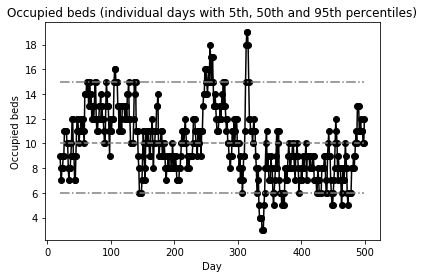

In [8]:
# Initialise environment
env=simpy.Environment()
# Initialise processes (admissions & bed audit)
env.process(new_admission(env,g.inter_arrival_time,g.los))
env.process(audit_beds(env,delay=20))
# Start simulation run
env.run(until=g.sim_duration)
# Build audit table
g.audit_dataframe=build_audit_report()
chart()